<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Basic/Neuron_apples_and_pears.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptron

Here we'll learn how to write a simple Rosenblatt's perceptron - the first neural network ever created.

Let's import some necessary libs first

In [101]:
!wget https://raw.githubusercontent.com/Dimildizio/DS_course/main/Neural_networks/Basic/data/apples_pears.csv

--2023-04-23 20:42:32--  https://raw.githubusercontent.com/Dimildizio/DS_course/main/Neural_networks/Basic/data/apples_pears.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42590 (42K) [text/plain]
Saving to: ‘apples_pears.csv.3’

apples_pears.csv.3  100%[===================>]  41.59K  --.-KB/s    in 0.01s   

2023-04-23 20:42:32 (3.90 MB/s) - ‘apples_pears.csv.3’ saved [42590/42590]



In [102]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score,f1_score, recall_score,precision_score
from sklearn.model_selection import train_test_split


In [103]:
df = pd.read_csv("apples_pears.csv")

Let's define a **Loss function**. Let it be **MSE**. We divide by 2 since $Δ{x^2} = 2x$ and it just makes the computations faster by cancelling 2s when updating the weights. 

$$\frac{1}{2n}\sum_{i=1}^{n} (f(w \cdot X_i + b) - y_i)^2$$  

In [104]:
def Loss(y_pred, y):
  '''mse'''
  return 1/2 * np.mean(y_pred - y, axis=0)**2

In [105]:
a = np.array([[10,20,30],[21,22,23],[23,24,25]])
b = a*2.5
Loss(b, a)

array([364.5, 544.5, 760.5])

## Some visualization

We need functions to take a loot at loss func over iterations, plot the result of classification and plot metrics

In [147]:
def plot_ap(X:np.array, target:np.array)->None:
  plt.scatter(X[:,0], X[:,1], c=target, cmap='spring')
  plt.title('Apples and pears')
  plt.xlabel('Symmetry')
  plt.ylabel('Yellowness')
  plt.show()

In [107]:
def plot_loss(losses:list)->None:
  """plot loss value by iteration"""
  plt.plot(losses)
  plt.title('Loss function')
  plt.xlabel('Iteration')
  plt.ylabel('Loss value')
  plt.show()

In [108]:
def print_score(y:pd.Series, y_pred:np.ndarray, name:str = 'Train')-> None:
  '''prints statistics for classification model'''
  print('print stats')
  print(name+' accuracy: ', accuracy_score(y, y_pred > 0.2))
  print(name+' F measure: ', f1_score(y, y_pred > 0.2))
  print(name+' ROC-AUC: ', roc_auc_score(y, y_pred))
  print()

## Perceptron class

We need functions that predict by applying WnB to the data (forward), that updats weigths while training (backward), activation function, training function and the one that predicts new data and prints some statistics.

In [222]:
class MyPerceptron:
  def __init__(self, w=None, b=0, lossfunc = 'mse'):
    self.w = w
    self.b = b
    self.lossfunc = lossfunc

  def init_wnb(self, x:int)->None:
    '''zeroes weights and biases'''
    if self.w is None:
      self.w = np.zeros((x, 1))
      self.b = 0
  
  @staticmethod
  def loss(y_pred, y, lossfunc = 'mse'):
    if lossfunc == 'mse':
      return 1/2 * np.mean(y_pred - y, axis=0)**2
    else:
      # neg mean(true y * log of probability X is y + false y * log of probability X is not y)
      cross_entropy = -np.mean(y * np.log(y_pred) + (1-y) * np.log(1 - y_pred), axis = 0)
      return cross_entropy

  def activate(self, n:np.array)->np.array:
    '''threshold activation function returns 1 if n > 0 else 0'''
    return np.array(n > 0, dtype = np.int32)

  def forward(self, X:np.array):
    '''predicting function that multiplies w*X +b and activates the neuron'''
    return self.activate(X @ self.w.reshape(X.shape[1],1) + self.b).reshape(-1,1)

  def backward(self, X:np.array, y:np.ndarray, y_pred:np.ndarray, lr:int = 5e-3):
    '''update the weights using gradient descent'''     
    self.w = self.w - (X.T @ (y_pred - y) /len(y)) * lr
    self.b = self.b - np.mean(y_pred - y, axis=0) * lr

  def fit(self, X:pd.DataFrame, y:pd.Series, n_iters:int=300)->list:
    '''train the model'''
    losses = []
    self.init_wnb(X.shape[1])
    y = np.array(y).reshape(-1,1)
    #backpropogation
    for n in range(n_iters):
      y_pred = self.forward(X)
      losses.append(self.loss(y_pred, y, self.lossfunc))
      self.backward(X, y, y_pred)
    return losses

  def run(self, X:np.array, y:np.array, name = 'Train') ->None:
    '''predict and show statistics'''
    y_pred = self.forward(X)
    print_score(y, y_pred, name)
    plot_ap(X, y_pred)


TYPE OF Y IS:  <class 'numpy.ndarray'>


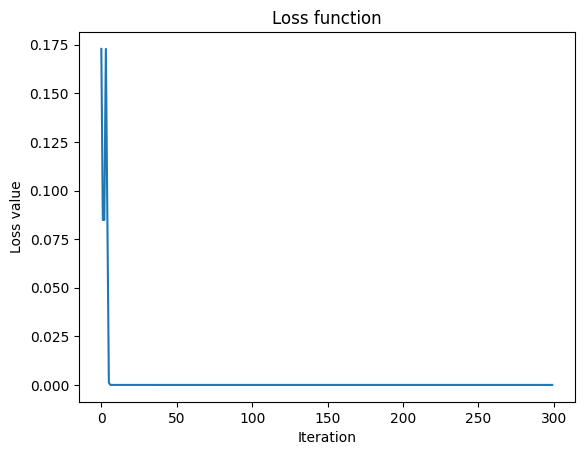

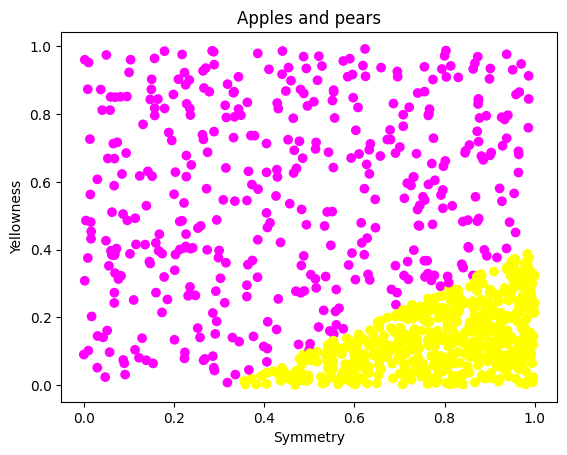

In [206]:
X = df[['yellowness', 'symmetry']].values
y = df['target'].values.reshape(-1,1)

perceptron = MyPerceptron()
losses = perceptron.fit(X, y)
y_pred = perceptron.forward(df[['yellowness', 'symmetry']])
plot_loss(losses)
plot_ap(df.values, y_pred)

In [207]:
X_train, X_test, y_train, y_test = train_test_split(df[['yellowness', 'symmetry']], df['target'], test_size = 0.3, stratify = df['target'], random_state=42)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

TYPE OF Y IS:  <class 'numpy.ndarray'>


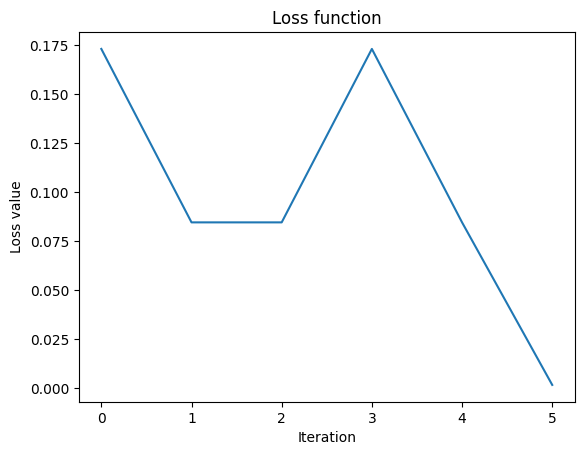

In [208]:
perc_new = MyPerceptron()
losses_new = perc_new.fit(X_train, y_train, n_iters = 6)
plot_loss(losses_new)

print stats
Train accuracy:  1.0
Train F measure:  1.0
Train ROC-AUC:  1.0



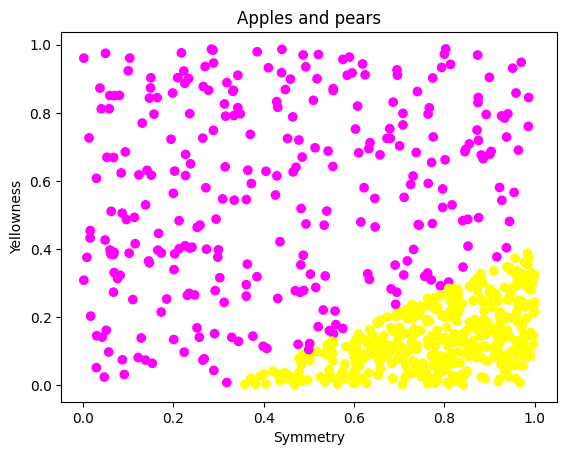

print stats
Test accuracy:  0.9966666666666667
Test F measure:  0.9971509971509972
Test ROC-AUC:  0.9971590909090908



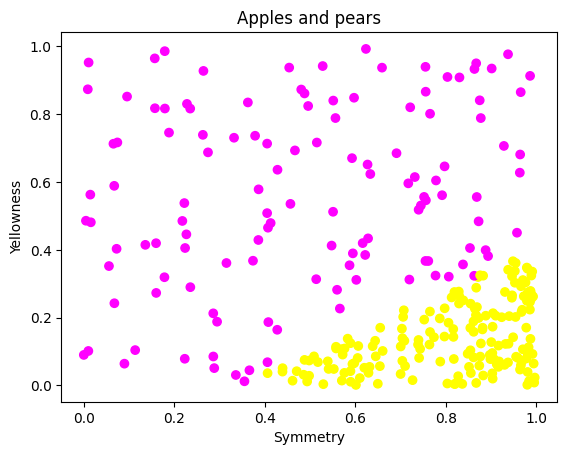

In [210]:
perc_new.run(X_train, y_train)
perc_new.run(X_test, y_test, 'Test')

# Neuron

Basically neuron is the same as rosenblatt's perceptron but the activation function is not a threshold one but could be chosen.

## Sigmoid activation function

Sigmoid activation function looks like this:

 $$\sigma(x)=\frac{1}{1+e^{-x}}$$


 So the loss function will be:

$$ \frac{1}{n}\sum_{i=1}^{n} (\frac{1}{1+e^{-w \cdot X_i}} - y_i)^2$$


The derivative of sigmoid is:

 $$\sigma(w \cdot x)(1-\sigma(w \cdot x))$$


For weight $w_j$ the loss function will be:

$$ \frac{\partial Loss}{\partial w_j} =  \frac{2}{n} \sum_{i=1}^n \left(\sigma(w \cdot x_i) - y_i\right)\sigma(w \cdot x_i)(1 - \sigma(w \cdot x_i))x_{ij}$$


And for the whole gradient it will be:

$$\frac{\partial Loss}{\partial w} = \frac{1}{n} X^T (\sigma(w \cdot X) - y)\sigma(w \cdot X)(1 - \sigma(w \cdot X))$$

In [211]:
def sigmoid(x):
  '''activation function'''
  return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
  """derivative of sigmoid function"""
  return sigmoid(x) * (1 - sigmoid(x))

In [212]:
class Neuron(MyPerceptron):
  
  def activate(self, x):
    return sigmoid(x)
  
  def backward(self, X, y, y_pred, lr = 0.1):
    sigma = self.activate(X @ self.w + self.b)
    err_sd = (sigma-y) * sigma * (1 - sigma)

    self.w = self.w - lr * (X.T @ err_sd) / len(y)
    self.b = self.b - lr * np.mean(err_sd, axis=0)


In [163]:
def mark_pred(y_pred:np.array)->np.array:
  return np.array([int(x+0.5) for x in y_pred]).reshape(-1,1)

def get_stats(model, X:np.array, y:np.array, name:str = 'Train')->None:
  y_pred = model.forward(X)
  y_pred = mark_pred(y_pred)
  print(name+' loss:',model.loss(y_pred, y.reshape(-1,1)))
  model.run(X, y, name)


In [197]:
def check_iters(neuron, its = 1000):
  log_loss= neuron.fit(X_train, y_train, n_iters = its)
  plot_loss(log_loss)
  get_stats(neuron, X_train, y_train)
  get_stats(neuron, X_test, y_test, 'Test')

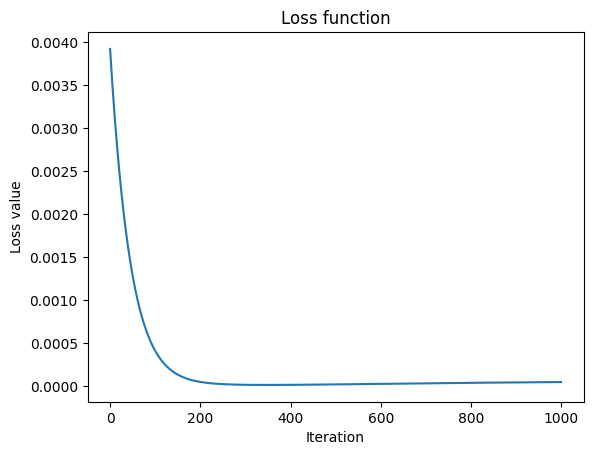

Train loss: [0.00589388]
print stats
Train accuracy:  0.6114285714285714
Train F measure:  0.7518248175182481
Train ROC-AUC:  0.9986599919093851



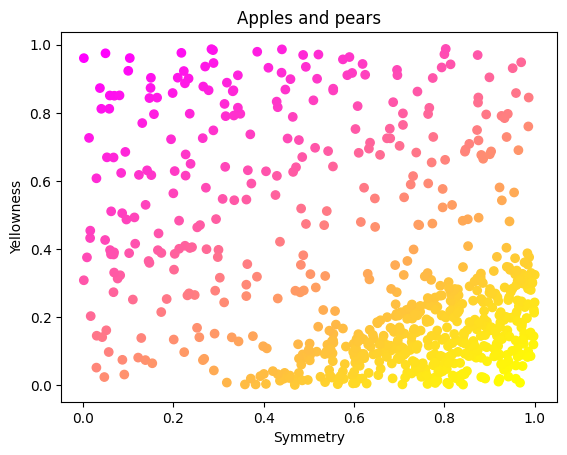

Test loss: [0.0098]
print stats
Test accuracy:  0.6033333333333334
Test F measure:  0.7473460721868366
Test ROC-AUC:  0.9983046187683285



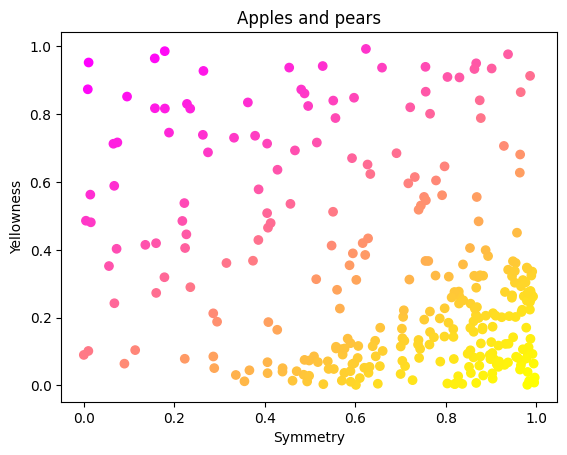

CPU times: user 958 ms, sys: 329 ms, total: 1.29 s
Wall time: 988 ms


In [213]:
%%time
neuron = Neuron()
new_loss= neuron.fit(X_train, y_train, n_iters = 1000)
plot_loss(new_loss)

get_stats(neuron, X_train, y_train)
get_stats(neuron, X_test, y_test, 'Test')

### Summary

So here is the gradient with sigmoid.
One thing to think about - using reshape(-1,1) on forward and backpropagation steps could increase the speed tenfold.

Anyways the thing is in classification problems **MSE** as Loss function is used close to never. Better option would be to use **LogLoss**

## Log Loss - cross entropy loss function

LogLoss is a binary function that evaluates probability of an input belonging to class A or B where 1.0 is A and 0.0 is B. In Cross entropy function (log loss) **y** is our **True** class (in our case apples) **1-y** is our **False** class (pears). 

$$-\frac{1}{n} \sum_{i=1}^n y_i ⋅ \log({y\_pred}) + (1 - y_i) \cdot \log(1-y\_pred)$$

1. First we take our **true y** and multiply it by a **log** of **probability** (*our prediction*) of ***x*** being class **A**.
2. Then we take the **opposite of** True **y** (*1 - y*) and multiply it by a **log of probability** of **x** not being class A (being class **B**).
3. After than we **sum** these result of **1** and **2** 
4. **Repeat** for every value in the prediction for xs
5. **Sum** it **all** up into a scalar
6. **Divide** **by** the **number of predictions**
7. **Multiply by -1**



In [165]:
# neg mean(true y * log of probability X is y + false y * log of probability X is not y)
cross_entropy = lambda y, y_pred: -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred), axis = 0)

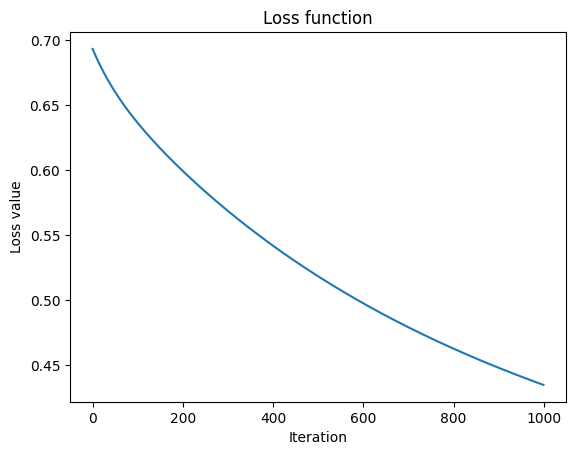

Train loss: [0.00589388]
print stats
Train accuracy:  0.6114285714285714
Train F measure:  0.7518248175182481
Train ROC-AUC:  0.9986599919093851



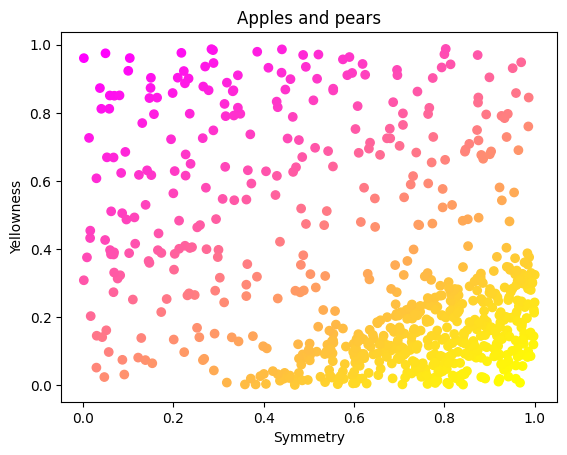

Test loss: [0.0098]
print stats
Test accuracy:  0.6033333333333334
Test F measure:  0.7473460721868366
Test ROC-AUC:  0.9983046187683285



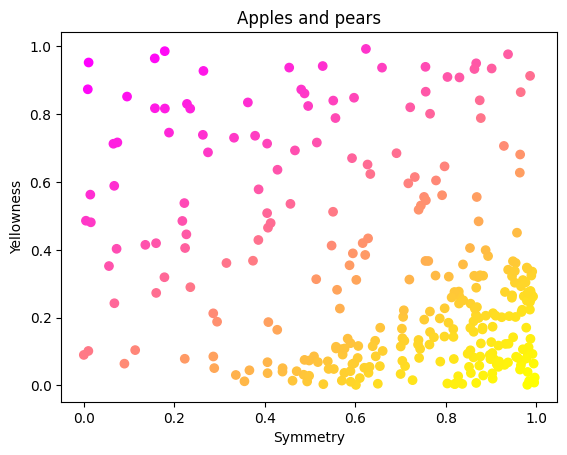

CPU times: user 917 ms, sys: 342 ms, total: 1.26 s
Wall time: 944 ms


In [214]:
%%time
neuron_ce = Neuron(lossfunc = 'logloss')

for num in [10^n for n in range(1,2)]:
  check_iters(neuron_ce, 1000)


# ReLU

ReLU is the boss of activation functions. We love it we need it, it works magic. Let's try it out.

In [200]:
def relu(x):
  return np.maximum(0,x)

def d_relu(x):
  x[x<=0] = 0
  x[x>0] = 1
  return x

In [295]:
class NeuronRelu(MyPerceptron):
  
  def activate(self, x):
    return relu(x)
  
  def backward(self, X, y, y_pred, lr = 0.005):
    relud = self.activate(X @ self.w + self.b)

    relu_derivative = d_relu(relud)
    y_diff = y_pred - y
    loss_gradient = y_diff * relu_derivative
    
    self.w = self.w - lr * (X.T @ loss_gradient) / len(y)
    self.b = self.b - lr * np.mean(loss_gradient, axis=0)


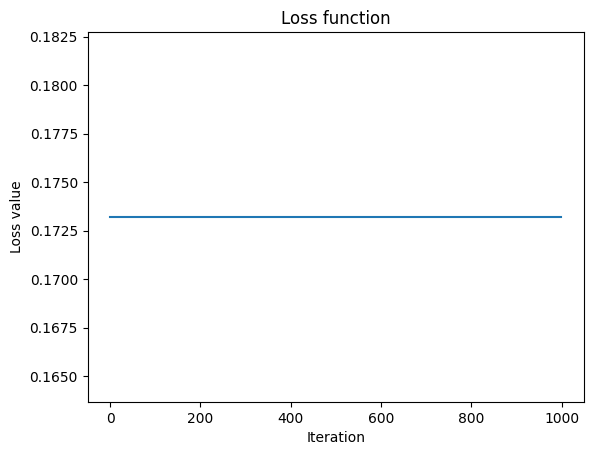

Train loss: [0.17320816]
print stats
Train accuracy:  0.4114285714285714
Train F measure:  0.0
Train ROC-AUC:  0.5



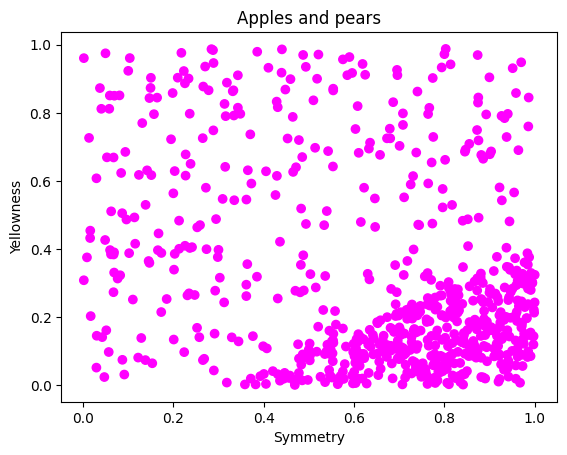

Test loss: [0.17208889]
print stats
Test accuracy:  0.41333333333333333
Test F measure:  0.0
Test ROC-AUC:  0.5



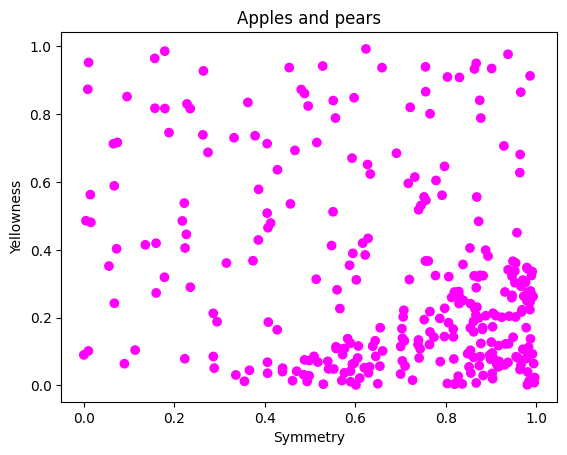

CPU times: user 890 ms, sys: 312 ms, total: 1.2 s
Wall time: 875 ms


In [247]:
%%time
rel = NeuronRelu()
check_iters(rel, 1000)

Oh, no'es! Our loss function is just a line. The gradient doesn't learn!

It doesn't. Weights are zeros. Let's init them.

<ipython-input-222-3d765e39f868>:19: RuntimeWarning: divide by zero encountered in log
  cross_entropy = -np.mean(y * np.log(y_pred) + (1-y) * np.log(1 - y_pred), axis = 0)
<ipython-input-222-3d765e39f868>:19: RuntimeWarning: invalid value encountered in multiply
  cross_entropy = -np.mean(y * np.log(y_pred) + (1-y) * np.log(1 - y_pred), axis = 0)


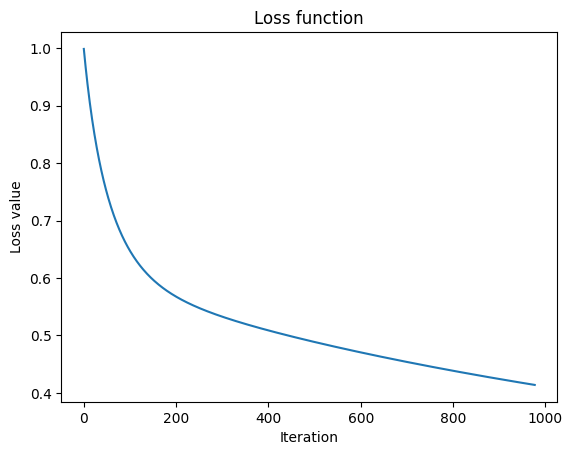

Train loss: [0.00754694]
print stats
Train accuracy:  0.6557142857142857
Train F measure:  0.7737089201877935
Train ROC-AUC:  0.9654379045307444



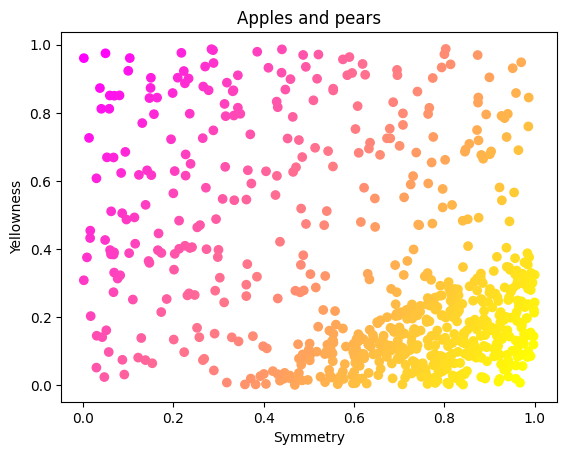

Test loss: [0.01333889]
print stats
Test accuracy:  0.6433333333333333
Test F measure:  0.7668845315904139
Test ROC-AUC:  0.9563324780058651



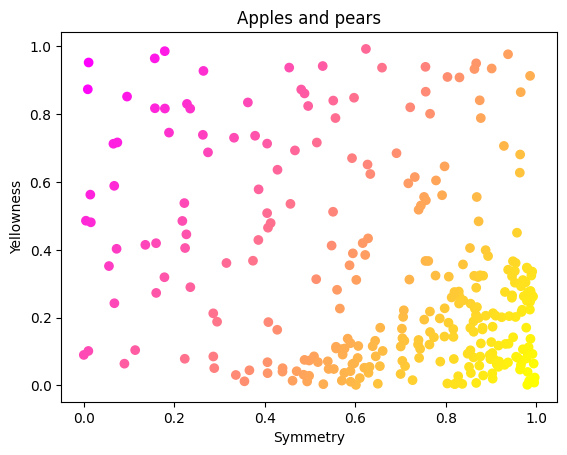

In [269]:
%%time
ws = np.random.rand(X_train.shape[1],1)
bs = np.random.rand(1)
np.random.seed(123456)

rel = NeuronRelu(w = ws, b = bs, lossfunc = 'logloss')
check_iters(rel, 1000)

In search for a gradient. It really depends on inited weights and biases.

Should be careful here and train again instead of additionally train the model now since we got w&bs initialized

<ipython-input-222-3d765e39f868>:19: RuntimeWarning: invalid value encountered in log
  cross_entropy = -np.mean(y * np.log(y_pred) + (1-y) * np.log(1 - y_pred), axis = 0)


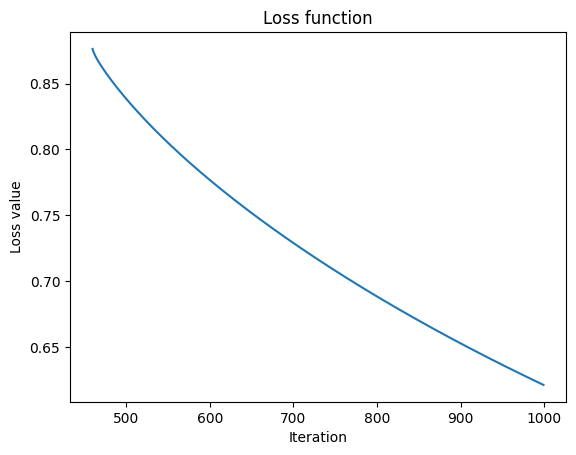

Train loss: [0.02]
print stats
Train accuracy:  0.5885714285714285
Train F measure:  0.7410071942446043
Train ROC-AUC:  0.6935932443365695



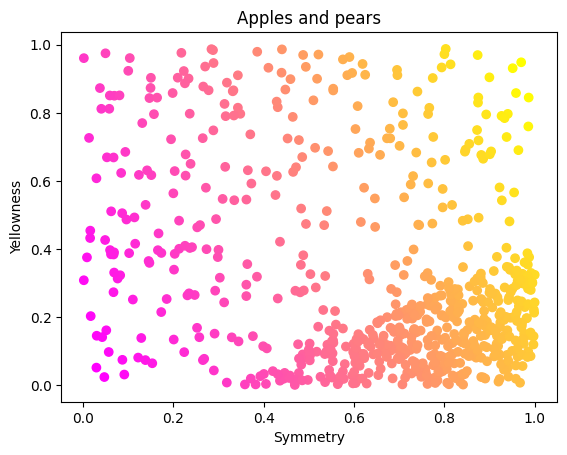

Test loss: [0.02347222]
print stats
Test accuracy:  0.5866666666666667
Test F measure:  0.7394957983193278
Test ROC-AUC:  0.6628482404692082



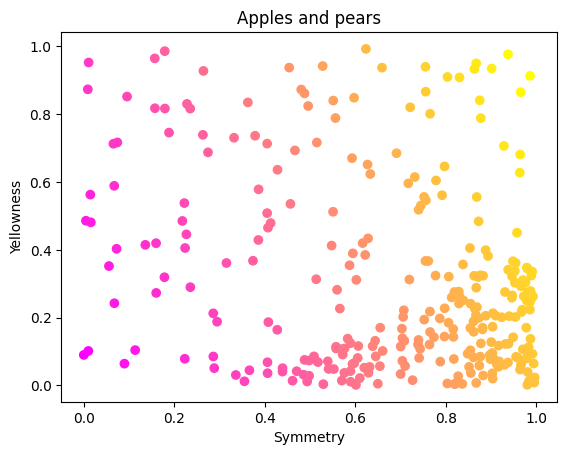

<ipython-input-222-3d765e39f868>:19: RuntimeWarning: invalid value encountered in log
  cross_entropy = -np.mean(y * np.log(y_pred) + (1-y) * np.log(1 - y_pred), axis = 0)


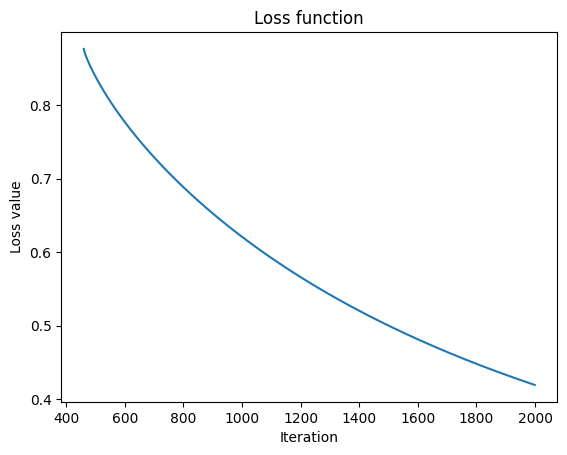

Train loss: [0.00772347]
print stats
Train accuracy:  0.6557142857142857
Train F measure:  0.7737089201877935
Train ROC-AUC:  0.9561589805825244



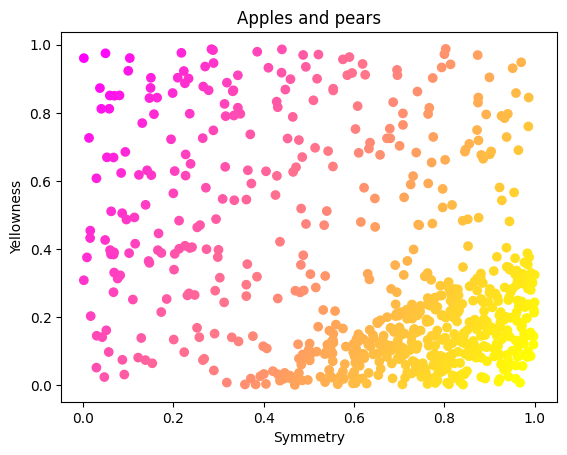

Test loss: [0.0128]
print stats
Test accuracy:  0.6433333333333333
Test F measure:  0.7668845315904139
Test ROC-AUC:  0.9461143695014662



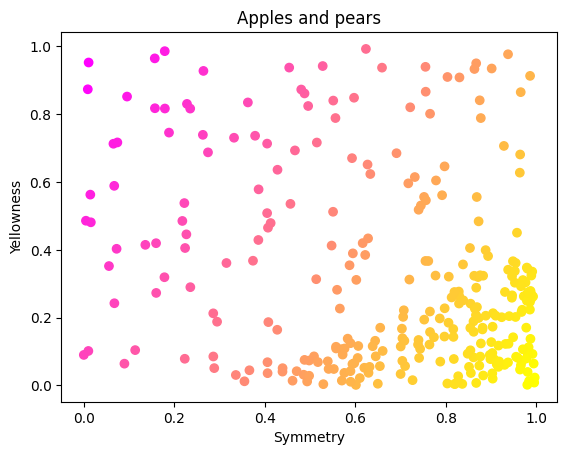

<ipython-input-222-3d765e39f868>:19: RuntimeWarning: invalid value encountered in log
  cross_entropy = -np.mean(y * np.log(y_pred) + (1-y) * np.log(1 - y_pred), axis = 0)
<ipython-input-222-3d765e39f868>:19: RuntimeWarning: divide by zero encountered in log
  cross_entropy = -np.mean(y * np.log(y_pred) + (1-y) * np.log(1 - y_pred), axis = 0)
<ipython-input-222-3d765e39f868>:19: RuntimeWarning: invalid value encountered in multiply
  cross_entropy = -np.mean(y * np.log(y_pred) + (1-y) * np.log(1 - y_pred), axis = 0)


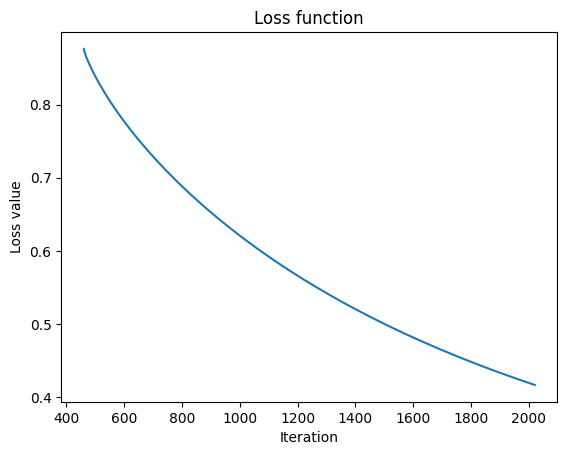

Train loss: [0.00139694]
print stats
Train accuracy:  0.8571428571428571
Train F measure:  0.8917748917748918
Train ROC-AUC:  0.9986094255663431



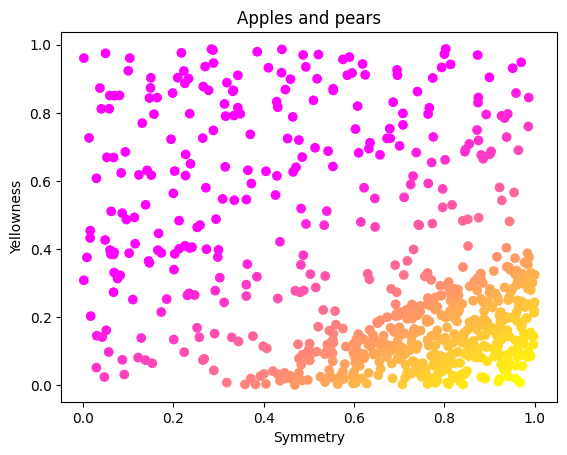

Test loss: [0.00160556]
print stats
Test accuracy:  0.8433333333333334
Test F measure:  0.8822055137844611
Test ROC-AUC:  0.99816715542522



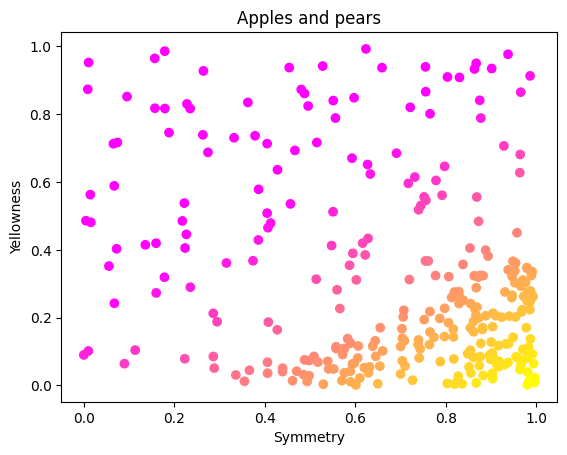

CPU times: user 5.36 s, sys: 593 ms, total: 5.96 s
Wall time: 6.36 s


In [293]:
%%time

ws = np.random.rand(X_train.shape[1],1)
bs = np.random.rand(1)
np.random.seed(42)

for n in [1000, 2000, 10000]:
  rel = NeuronRelu(w = ws, b = bs, lossfunc = 'logloss')
  check_iters(rel, n)

Iterations do matter in finding the minumum. Interestingly the loss graph doesn't want to show anything below and above certain numbers depending on the initial and final step sizes. Guess when the step is too small.

# Leaky ReLU

Leaky ReLU is similar to ReLU but normally learns faster since there is a small negative number below zero instead of 0 when x <=0  that mitigates the problem of dead neurons.

Returns *alpha* * x if x <=0 or x if x > 0

Derivative is *alpha* if x <=0 or 1 if x > 0

In [315]:
alpha = 0.01
def leaky_relu(x, a = alpha):
  return np.maximum(a*x, x)

def d_leaky_relu(x, a = alpha):
  x[x<=0] = a
  x[x>0] = 1
  return x

In [318]:
class NeuronLeakyRelu(MyPerceptron):
  
  def activate(self, x):
    return leaky_relu(x)
  
  def backward(self, X, y, y_pred, lr = 0.05):
    l_relud = self.activate(X @ self.w + self.b)

    d_l_relu = d_leaky_relu(l_relud)
    y_diff = y_pred - y
    gradient_loss = y_diff * d_l_relu

    self.w = self.w - lr * (X.T @ gradient_loss) / len(y)
    self.b = self.b - lr * np.mean(gradient_loss, axis = 0)

<ipython-input-222-3d765e39f868>:19: RuntimeWarning: invalid value encountered in log
  cross_entropy = -np.mean(y * np.log(y_pred) + (1-y) * np.log(1 - y_pred), axis = 0)


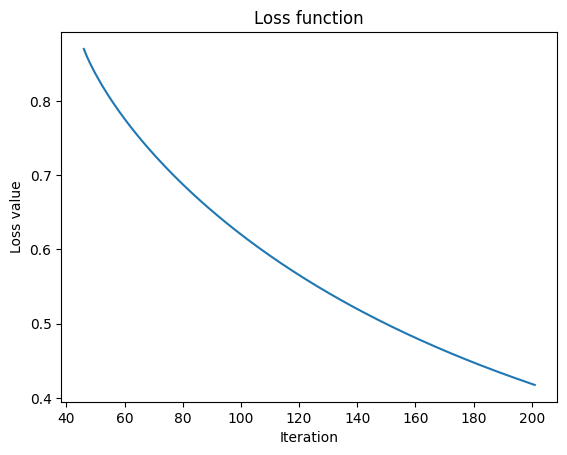

Train loss: [0.00139694]
print stats
Train accuracy:  0.8571428571428571
Train F measure:  0.8917748917748918
Train ROC-AUC:  0.9986009978425027



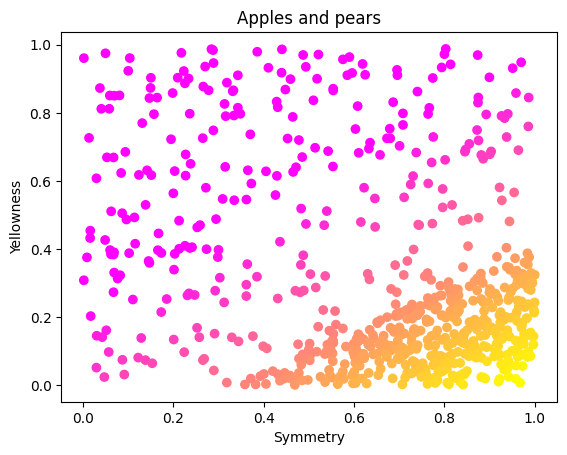

Test loss: [0.0018]
print stats
Test accuracy:  0.8433333333333334
Test F measure:  0.8822055137844611
Test ROC-AUC:  0.998075513196481



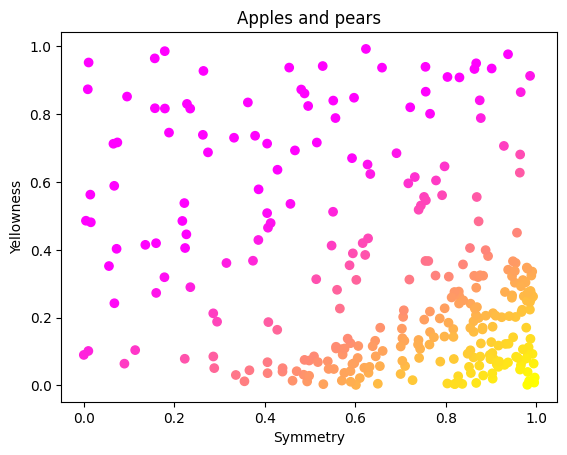

CPU times: user 1.57 s, sys: 123 ms, total: 1.69 s
Wall time: 2.94 s


In [334]:
%%time
l_rel = NeuronLeakyRelu(w = ws, b = bs, lossfunc = 'logloss')
check_iters(l_rel, 1000)

The rate of change depends of course on learning rate and a bit on alpha. But it solves problem of dead neurons. Claims are made that it doesn't work really well if we got noise.

#ELU

An upgrade to LeakyReLU 

**Function** is:  $aplha(e^x -1)$ if $x <= 0$ and **x** if $x > 0$

**derivative** is: $ELU(alpha, x) + alpha$ if $x <= 0$ or **1** if $x > 0$

In [328]:
e_alpha = 0.001
def elu(x, a = e_alpha):
  return np.where(x<=0, a * (np.exp(x) -1), x)

def d_elu(x, a=e_alpha):
  return np.where (x<=0, elu(x,a)+a, 1)

In [329]:
class NeuronElu(MyPerceptron):
  def activate(self, x):
    return elu(x)
  
  def backward(self, X, y, y_pred, lr = 0.05):
    y_diff = y_pred-y
    elud = elu(X @ self.w + self.b)
    d_elued = d_elu(elud)
    gradient_loss = y_diff * elud

    self.w = self.w - lr * (X.T @ gradient_loss) / len(y)
    self.b = self.b - lr * np.mean(gradient_loss, axis = 0)

<ipython-input-222-3d765e39f868>:19: RuntimeWarning: invalid value encountered in log
  cross_entropy = -np.mean(y * np.log(y_pred) + (1-y) * np.log(1 - y_pred), axis = 0)


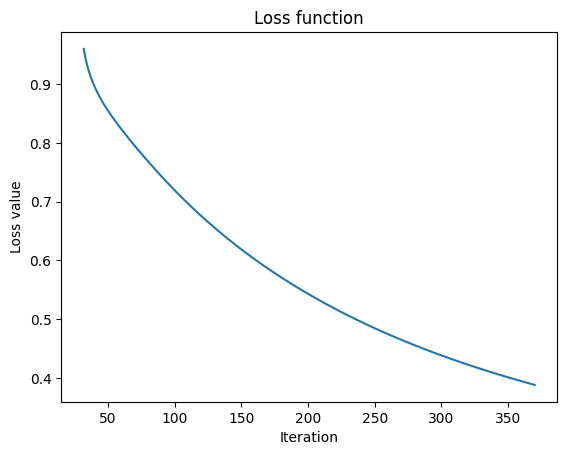

Train loss: [0.00188673]
print stats
Train accuracy:  0.8314285714285714
Train F measure:  0.8747346072186837
Train ROC-AUC:  0.9993847761596548



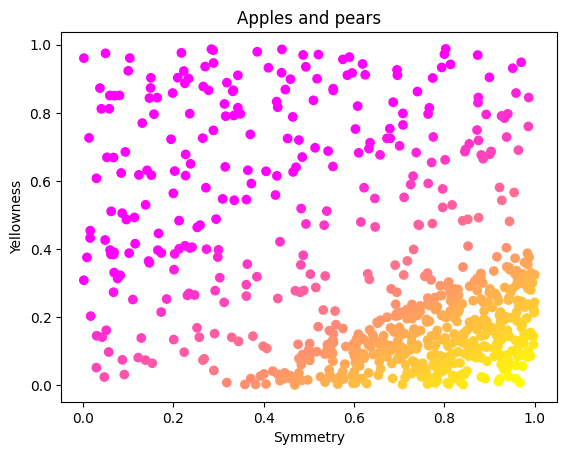

Test loss: [0.00268889]
print stats
Test accuracy:  0.8233333333333334
Test F measure:  0.8691358024691358
Test ROC-AUC:  0.9992210410557185



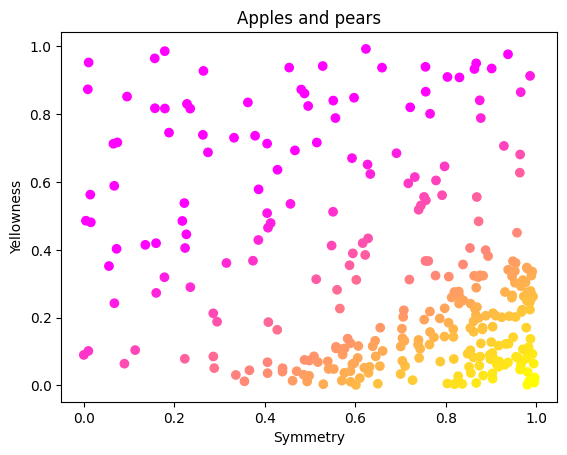

CPU times: user 1.79 s, sys: 93.9 ms, total: 1.88 s
Wall time: 2.92 s


In [332]:
%%time
nelu = NeuronElu(w = ws, b = bs, lossfunc = 'logloss')
check_iters(nelu, 2000)

Wow! This one is definitely finding the minimum earlier (on this dataset). Usual Relu at this point doesn't even want to show the graph yet! Look at the statistics (accuracy still pretty low though).

Since the equation is more complex the computation is longer which is not felt on this task and dataset.

#Other activation functions

There are many. One should remember this picture.

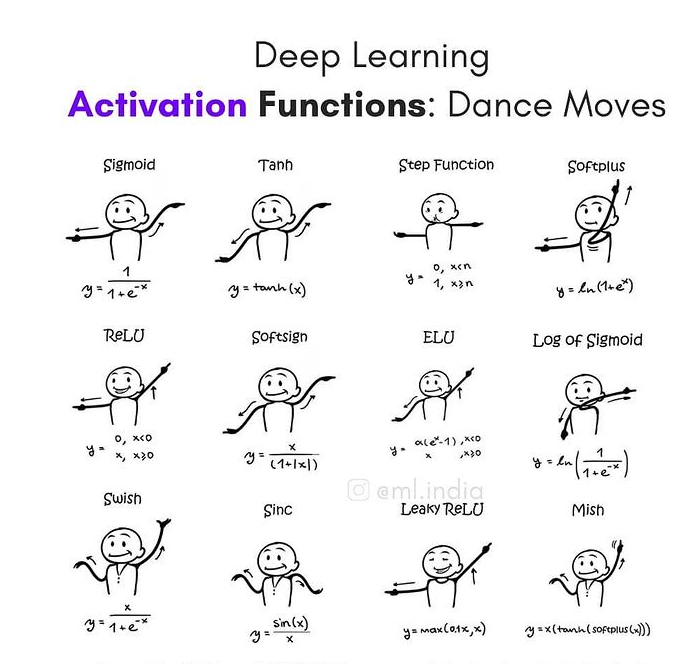